# Economic Value Added

Economic value added (EVA) is an estimate of a company's economic profit. It measures how much a firm's returns exceed those required by suppliers of capital. In other words it tells one how much wealth the firm has created for company shareholders. EVA is the net profit less the capital charge for raising the company's capital. The idea is that value is created when the return on the firm's economic capital employed exceeds the cost of that capital.
There are two ways to calculate EVA. The first one is
>EVA = NOPAT - WACC * Total Capital

In the above formula NOPAT is the net operating profit after tax, WACC is weighted average cost of capital and Total Capital is the sum of debt and equity.

The second formula for EVA is
>EVA = EBIT * (1 - t) - \\$WACC

Here EBIT is earnings before interest and tax, t is the marginal tax rate and \\$WACC is the dollar cost of capital.

In this example we're using the first formula to calculate EVA

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import matplotlib
%matplotlib inline
import eikon as ek
# replace this with your Eikon API key
EIKON_APP_KEY = os.environ.get('EIKON_APP_KEY')
if EIKON_APP_KEY==None:
    print('App key is needed to retrieve data from Eikon. Generate your app key and use it in ek.set_app_key call.')
else:
    ek.set_app_key(EIKON_APP_KEY)

In [2]:
#Input stock RIC of a company
stock_ric = 'IBM.N'

In [3]:
company_info_df, err = ek.get_data(stock_ric,['TR.CommonName',
                                              'TR.HeadquartersCountry',
                                              'TR.ExchangeName',
                                              'TR.TRBCIndustryGroup',
                                              'TR.TRBCSector',
                                              'TR.CompanyReportCurrency'])
company_info_df = company_info_df.set_index(['Instrument'])
curr = company_info_df.loc[stock_ric,'Currency Code']
display(company_info_df.T)

Instrument,IBM.N
Company Common Name,International Business Machines Corp
Country of Headquarters,United States of America
Exchange Name,"NEW YORK STOCK EXCHANGE, INC."
TRBC Industry Group Name,Software & IT Services
Currency Code,USD


### NOPAT
Net operating profit after tax (NOPAT) is a company's after-tax operating profit with certain adjustments. The adjustments may include removing the effects of goodwill and other non-cash items, treating R&D expenditure as an investment rather than a current expenditure and treating operating lease rentals as interest. In the example below we add supplemental rental expense to the operating income for the purpose of calculating NOPAT.

In [4]:
nopat_df, err = ek.get_data(stock_ric, ['TR.OperatingIncome.ped',
                                        'TR.OperatingIncome',
                                        'TR.RentalExpenseSupplemental',
                                        'TR.ProvisionForIncomeTaxes'],
                           {'Scale':'6', 'Period':'FY0:FY-3', 'Frq':'FY'})
nopat_df.drop('Instrument', axis=1, inplace=True)
nopat_df = nopat_df.set_index(['Period End Date'])
nopat_df['Provision for Income Taxes'] = -nopat_df['Provision for Income Taxes']
nopat_df['Net Operating Profit After Tax'] = nopat_df.sum(axis=1)
display(nopat_df.T.style.format('{:,.0f}'))

Period End Date,2018-12-31,2017-12-31,2016-12-31,2015-12-31
Operating Income,"11,342","11,400","12,330","15,944"
"Rental Expense, Supplemental","1,944","1,821","1,508","1,474"
Provision for Income Taxes,-582,-167,-449,"-2,581"
Net Operating Profit After Tax,"12,704","13,054","13,389","14,837"


### Total adjusted capital
Total Adjusted Capital is calculated as sum of Total Debt and Equity adjusted for Goodwill Amortization, Present Value of Operating Lease Obligations and any other relevant adjustment depending upon the business.

In [5]:
tot_adj_cap_df, err = ek.get_data(stock_ric, ['TR.TotalDebt.ped',
                                              'TR.TotalDebt',
                                              'TR.MinorityInterestBSStmt',
                                              'TR.RedeemablePreferredTtl',
                                              'TR.PreferredStockNonRedeemableNet',
                                              'TR.TotalEquity',
                                              'TR.AccumulatedGoodwillAmortSuppl',
                                              'TR.OperatingLeasePymtsDueinYear1',
                                              'TR.OperatingLeasePymtsDueinYear2',
                                              'TR.OperatingLeasePymtsDueinYear3',
                                              'TR.OperatingLeasePymtsDueinYear4',
                                              'TR.OperatingLeasePymtsDueinYear5',
                                              'TR.OperatingLeasePymtsDueinYear6AndBeyond',],
                                  {'Scale':'6', 'Period':'FY0:FY-3', 'Frq':'FY'})
tot_adj_cap_df.drop('Instrument', axis=1, inplace=True)
tot_adj_cap_df = tot_adj_cap_df.set_index(['Period End Date'])
cost_of_debt = ek.get_data(stock_ric,'TR.WACCCostofDebt')[0].iloc[0,1]
tmp_df = tot_adj_cap_df[['Operating Lease Payments Due in Year 1',
                'Operating Lease Payments Due in Year 2',
                'Operating Lease Payments Due in Year 3',
                'Operating Lease Payments Due in Year 4',
                'Operating Lease Payments Due in Year 5',
                'Oper Lease Pmnts Due in Years 6 and Beyond']]
tmp_df.insert(0,'Operating Lease Payments Due in Year 0',0)
tot_adj_cap_df['Present Value of Operating Leases'] = tmp_df.apply(lambda x: np.npv(cost_of_debt, x), axis=1)
tot_adj_cap_df.drop(columns = tmp_df.columns, errors='ignore', inplace=True)
tot_adj_cap_df['Total Adjusted Capital'] = tot_adj_cap_df.sum(axis=1)
display(tot_adj_cap_df.T.style.format('{:,.0f}'))

Period End Date,2018-12-31,2017-12-31,2016-12-31,2015-12-31
Total Debt,"45,812","46,824","42,168","39,889"
Minority Interest,134,131,146,162
"Redeemable Preferred Stock, Total",nan,nan,nan,nan
"Preferred Stock - Non Redeemable, Net",nan,nan,nan,nan
Total Equity,"16,795","17,594","18,246","14,262"
Accumulated Goodwill Amortization Suppl.,nan,nan,nan,nan
Present Value of Operating Leases,514,543,485,459
Total Adjusted Capital,"63,255","65,092","61,045","54,772"


### EVA
Since WACC is calculated by Refinitiv StarMine analytics and can be directly retrieved from Eikon, we're now ready to calculate EVA. In addition to calculating EVA in dollar terms we're also calculating EVA as a percentage of Total Adjusted Capital.

In [6]:
eva_df, err = ek.get_data(stock_ric,['TR.WACC.date','TR.WACC'],{'SDate':0, 'EDate':-3, 'Frq':'FY'})
eva_df['Weighted Average Cost of Capital'] = eva_df['Weighted Average Cost of Capital, (%)'] / 100
eva_df.drop(['Instrument','Weighted Average Cost of Capital, (%)'], axis=1, inplace=True)
eva_df['Date'] = eva_df['Date'].str.slice(0,10)
eva_df = eva_df.set_index(['Date'])
eva_df['NOPAT'] = nopat_df['Net Operating Profit After Tax']
eva_df['Total Adjusted Capital'] = tot_adj_cap_df['Total Adjusted Capital']
eva_df['Cost of Capital'] = eva_df['Total Adjusted Capital'] * eva_df['Weighted Average Cost of Capital']
eva_df['NOPAT Return on Adjusted Capital'] = eva_df['NOPAT'] / eva_df['Total Adjusted Capital']
eva_df['Economic Value Added ($)'] = eva_df['NOPAT'] - eva_df['Cost of Capital']
eva_df['Economic Value Added (%)'] = (eva_df['NOPAT Return on Adjusted Capital'] - 
                                     eva_df['Weighted Average Cost of Capital'])
format_mapper = {'NOPAT':'{:,.0f}','Total Adjusted Capital':'{:,.0f}','Cost of Capital':'{:,.0f}',
                 'Economic Value Added ($)':'{:,.0f}','Weighted Average Cost of Capital':'{:.2%}',
                 'NOPAT Return on Adjusted Capital':'{:.2%}','Economic Value Added (%)':'{:.2%}'}
display(eva_df.T.apply(lambda s: s.map(format_mapper.get(s.name).format), axis=1))

Date,2018-12-31,2017-12-31,2016-12-31,2015-12-31
Weighted Average Cost of Capital,7.92%,5.99%,6.44%,5.13%
NOPAT,"12,704","13,054","13,389","14,837"
Total Adjusted Capital,"63,255","65,092","61,045","54,772"
Cost of Capital,"5,010","3,900","3,934","2,810"
NOPAT Return on Adjusted Capital,20.08%,20.05%,21.93%,27.09%
Economic Value Added ($),"7,694","9,154","9,455","12,027"
Economic Value Added (%),12.16%,14.06%,15.49%,21.96%


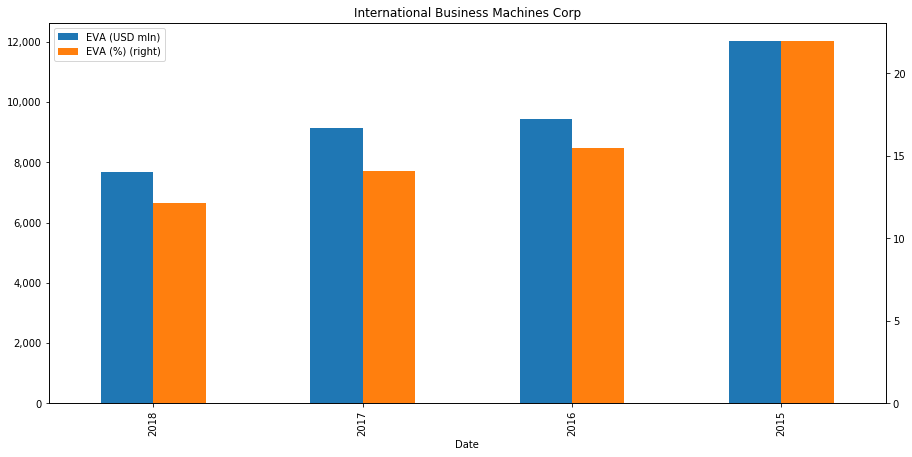

In [7]:
plot_df = pd.DataFrame({'EVA (' + curr + ' mln)': eva_df['Economic Value Added ($)'].tolist(),
                       'EVA (%)': (eva_df['Economic Value Added (%)'] * 100).tolist()},
                       index = eva_df.index.str.slice(0,4))
ax = plot_df.plot.bar(secondary_y='EVA (%)', figsize=(15,7), 
                      title=company_info_df.loc[stock_ric,'Company Common Name'])
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))